In [1]:
import torch
import torchvision

In [ ]:
# Downloading dataset
train_set = torchvision.datasets.FashionMNIST(root="data/", download=True)

# Defining util funtions

In [133]:
import os
import struct
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import cross_val_score

def normalize(images):
    return ((images / 255.) - .5) *2

def load_fashionmnist(path, kind='train'):
    labels_path = os.path.join(path,
                              f'{kind}-labels-idx1-ubyte')
    images_path = os.path.join(path,
                              f'{kind}-images-idx3-ubyte')
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)
        
    with open(images_path, 'rb') as imgpath:
        magic, n, rows, cols = struct.unpack('>IIII', imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
        
    return images, labels

def plot_fashion_classes_samples(images, labels):
    fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
    ax = ax.flatten()
    for i in range(10):
        img = images[labels == i][0].reshape(28, 28)
        ax[i].imshow(img, cmap='Greys')
        
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.tight_layout()
    plt.show()
    return plt
    
def plot_fashion_samples_5x5(images, label):
    fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
    ax = ax.flatten()
    for i in range(25):
        img = images[labels == label][i].reshape(28, 28)
        ax[i].imshow(img, cmap='Greys')
        
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.tight_layout()
    plt.show()
    return plt
    
def classify_acc_f1(classifier, X_test, y_test):
    y_pred = classifier.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy, f1

def batch_generator(X, y, batch_size=64, shuffle=False, random_seed=None):
    idx = np.arange(y.shape[0])
    
    if shuffle:
        rng = np.random.RandomState(random_seed)
        rng.shuffle(idx)
        X = X[idx]
        y = y[idx]
    
    for i in range(0, X.shape[0], batch_size):
        yield (X[i: i + batch_size, :], y[i: i + batch_size])

## Visualisation

In [134]:
images, labels = load_fashionmnist('data/FashionMNIST/raw/')

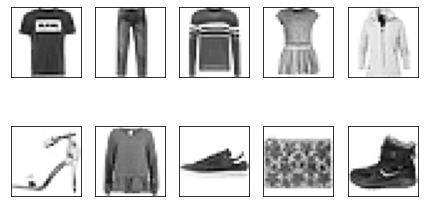

<Figure size 432x288 with 0 Axes>

In [135]:
plt = plot_fashion_classes_samples(images, labels)
plt.savefig('docimg/classes_single_exampels.png')

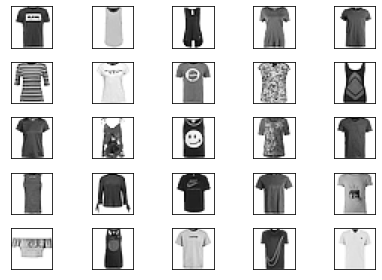

<Figure size 432x288 with 0 Axes>

In [137]:
plt = plot_fashion_samples_5x5(images, 0)
plt.savefig('docimg/single_class_exampels.png')

# Logistic Regression Model

## Data extraction

In [2]:
X_train, y_train = load_fashionmnist('data/FashionMNIST/raw/')
X_test, y_test = load_fashionmnist('data/FashionMNIST/raw/', kind='t10k')
X_train = normalize(X_train)
X_test = normalize(X_test)

## Features Extraction

In [12]:
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(n_components=20)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)

## Model training and evaluation

### With Principal Component Analysis

In [13]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression

param_grid = {'C': [0.1, 1.0, 10],
              'fit_intercept': [True, False],
              'intercept_scaling': [0.1, 1.0, 2.0]}

classifier = LogisticRegression(n_jobs=-1)

gs = GridSearchCV(estimator=classifier,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=5,
                  n_jobs=-1)

gs.fit(X_train_pca, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.8090499999999998
{'C': 0.1, 'fit_intercept': True, 'intercept_scaling': 0.1}


In [14]:
lr_best = gs.best_estimator_
accuracy, f1 = classify_acc_f1(lr_best, X_test_pca, y_test)
print(f'F1 score: {f1}')
print(f'Accuracy: {accuracy}')

F1 score: 0.4287301458912836
Accuracy: 0.438


### Without Principal Component Analysis

In [4]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression

param_grid = {'C': [0.1, 1.0, 10],
              'fit_intercept': [True, False],
              'intercept_scaling': [0.1, 1.0, 2.0]}

classifier = LogisticRegression(n_jobs=-1)

gs = GridSearchCV(estimator=classifier,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=5,
                  n_jobs=-1)

gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.8567333333333333
{'C': 0.1, 'fit_intercept': False, 'intercept_scaling': 0.1}


In [10]:
lr_best = gs.best_estimator_
acc, f1_ = classify_acc_f1(lr_best, X_test, y_test)
print(f'F1 score: {f1_}')
print(f'Accuracy: {accuracy}')

F1 score: 0.8431083469320838
Accuracy: 0.8439


# Convolutional Neural Network Model

## Features Extraction

In [15]:
X_train, y_train = load_fashionmnist('data/FashionMNIST/raw/')
X_test, y_test = load_fashionmnist('data/FashionMNIST/raw/', kind='t10k')

X_train = X_train.reshape(28, 28, 60000)
X_test = X_test.reshape(28, 28, 10000)

X_train_centered = normalize(X_train)
X_test_centered = normalize(X_test)

# mean_vals = np.mean(X_train, axis=0)
# std_val = np.std(X_train)
# X_train_standarized = (X_train - mean_vals) / std_val
# X_test_standarized = (X_test - mean_vals) / std_val

In [112]:
import torch
import torchvision
import torchvision.transforms as transforms

# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize(0.5, 0.5)]
# )

transform = transforms.Compose(
    [transforms.ToTensor()]
)


batch_size = 16

train_set = torchvision.datasets.FashionMNIST(root="data/", train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)

test_set = torchvision.datasets.FashionMNIST(root="data/", train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4)

## Model

### Simple CNN Conv(1, 32, 5) Pool(2, 2) Conv(32, 64, 5) Pool(2, 2) FC(1024, 10) no Batch Norm, no Dropout

In [16]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(64 * 4 * 4, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

### CNN Conv(1, 32, 5) Pool(2, 2) Conv(32, 64, 5) Pool(2, 2) FC(1024, 10) Batch Norm, no Dropout

In [44]:
import torch.nn as nn

class CNNBatchNorm(nn.Module):
    def __init__(self):
        super().__init__()

        self._conv_layer = nn.Sequential(
            nn.Conv2d(1, 32, 5),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, 5),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Flatten()
        )
        
        self._linear_layer = nn.Sequential(
            nn.Linear(1024, 10)
        )
    
    def forward(self, x):
        x = self._conv_layer(x)
        x = self._linear_layer(x)
        return x

### CNN Conv(1, 32, 5) Pool(2, 2) Conv(32, 64, 5) Pool(2, 2) FC(1024, 512) FC(512, 256) FC(256, 10) Batch Norm, no Dropout

In [105]:
import torch.nn as nn

class CNNBatchNormFC3(nn.Module):
    def __init__(self):
        super().__init__()

        self._conv_layer = nn.Sequential(
            nn.Conv2d(1, 32, 5),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, 5),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Flatten()
        )
        
        self._linear_layer = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 10)
        )
    
    def forward(self, x):
        x = self._conv_layer(x)
        x = self._linear_layer(x)
        return x

### CNN Vgg Like Conv(1, 16, 3, pad='same') Conv(16, 16, 3, pad='same') Pool(2) Conv(16, 32, 5) Conv(32, 32, 5) Pool(2) FC(800, 800) FC(800, 512) FC(512, 10)

In [97]:
import torch.nn as nn

class CNNVggLike2(nn.Module):
    def __init__(self):
        super().__init__()

        self._conv_layer = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            
            nn.Conv2d(16, 16, 3, padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(16, 32, 5, padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(32, 32, 5, padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            
            nn.MaxPool2d(2, 2),
            
            nn.Flatten()
        )
        
        self._linear_layer = nn.Sequential(
            nn.Linear(800, 800),
            nn.ReLU(),
            
            nn.Linear(800, 512),
            nn.ReLU(),
            
            nn.Linear(512, 10)
        )
    
    def forward(self, x):
        x = self._conv_layer(x)
        x = self._linear_layer(x)
        return x

### CNN Vgg Like Conv(1, 16, 3, pad='same') Conv(16, 16, 3, pad='same') Pool(2) Conv(16, 32, 5) Conv(32, 32, 5) Pool(2) FC(800, 800) FC(800, 512) FC(512, 10) Pool = AvgPool

In [129]:
import torch.nn as nn

class CNNVggLikeAvgPool(nn.Module):
    def __init__(self):
        super().__init__()

        self._conv_layer = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            
            nn.Conv2d(16, 16, 3, padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            
            nn.AvgPool2d(2, 2),
            
            nn.Conv2d(16, 32, 5, padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(32, 32, 5, padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            
            nn.AvgPool2d(2, 2),
            
            nn.Flatten()
        )
        
        self._linear_layer = nn.Sequential(
            nn.Linear(800, 800),
            nn.ReLU(),
            
            nn.Linear(800, 512),
            nn.ReLU(),
            
            nn.Linear(512, 10)
        )
    
    def forward(self, x):
        x = self._conv_layer(x)
        x = self._linear_layer(x)
        return x

### CNN Concat

In [90]:
import torch.nn as nn

class CNNConcat(nn.Module):
    def __init__(self):
        super().__init__()

        self._conv_layer = nn.Sequential(
            nn.Conv2d(32, 64, 5, padding=(2, 2)),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            
            nn.Conv2d(64, 64, 5, padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            
            nn.Conv2d(64, 64, 5, padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            
            nn.MaxPool2d(2, 2),
            
            nn.Flatten()
        )
        
        self._conv_par = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            
            nn.Conv2d(16, 16, 3, padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            
            nn.MaxPool2d(2, 2),
        )
        
        self._linear_layer = nn.Sequential(
            nn.Linear(1600, 1600),
            nn.ReLU(),
            
            nn.Linear(1600, 800),
            nn.ReLU(),
            
            nn.Linear(800, 10)
        )
    
    def forward(self, x):
        x1 = self._conv_par(x)
        x2 = self._conv_par(x)
        x = torch.cat([x1, x2], dim=1)
        x = self._conv_layer(x)
        x = self._linear_layer(x)
        return x

## Model Training

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [125]:
import torch.optim as optim

cnn = CNNVggLikeAvgPool()
cnn = cnn.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

In [128]:
epochs = 5
for epoch in range(epochs):
    running_loss = 0.0
    
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 200 == 199:
            print(f'Epoch: [{epoch + 1}, {i + 1}], loss: {running_loss / 199}')
            running_loss = 0.0

print('Finished Training')

Epoch: [1, 200], loss: 0.24842940437041186
Epoch: [1, 400], loss: 0.23812441488999367
Epoch: [1, 600], loss: 0.23010311395645927
Epoch: [1, 800], loss: 0.2362475659342567
Epoch: [1, 1000], loss: 0.2535154948844083
Epoch: [1, 1200], loss: 0.2658089941025866
Epoch: [1, 1400], loss: 0.2466674024407663
Epoch: [1, 1600], loss: 0.22816793396413776
Epoch: [1, 1800], loss: 0.22905904656023385
Epoch: [1, 2000], loss: 0.23096826365545167
Epoch: [1, 2200], loss: 0.23869346587242438
Epoch: [1, 2400], loss: 0.23734882135580682
Epoch: [1, 2600], loss: 0.2557150310598052
Epoch: [1, 2800], loss: 0.24010121813465155
Epoch: [1, 3000], loss: 0.24019882363271922
Epoch: [1, 3200], loss: 0.2414898629202016
Epoch: [1, 3400], loss: 0.2162498147858672
Epoch: [1, 3600], loss: 0.2515367230437883
Epoch: [2, 200], loss: 0.21586952211999863
Epoch: [2, 400], loss: 0.233189518432409
Epoch: [2, 600], loss: 0.2389245038646175
Epoch: [2, 800], loss: 0.24258484142474437
Epoch: [2, 1000], loss: 0.22854031929184668
Epoch: 

KeyboardInterrupt: 

In [119]:
torch.save(cnn.state_dict(), 'models/vgg_avgpool_cnn.pth')

## Model Evaluation

In [110]:
cnn = CNNConcat()
cnn.load_state_dict(torch.load('models/concat_cnn.pth'))
cnn.to(device)

CNNConcat(
  (_conv_layer): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Flatten(start_dim=1, end_dim=-1)
  )
  (_conv_par): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4):

In [127]:
from torch import Tensor

correct = 0
total = 0
with torch.no_grad():
    y_pred = []
    y_test = []
    for data in testloader:
        images, labels = data
        images = images.to(device)
        y_test.extend(labels)
        
        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        y_pred.extend(Tensor.cpu(predicted))
        
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(f'F1-Score: {f1}')

Accuracy: 0.9031
F1-Score: 0.9019987668167505


# Results

##### LogisticRegression:
Accuracy: 84.39%<br>
F1-Score: 84.31%<br>

##### Simple CNN Conv(1, 32, 5) Pool(2, 2) Conv(32, 64, 5) Pool(2, 2) FC(1024, 10) no Batch Norm, no Dropout:
Accuracy: 87.75%<br>
F1-Score: 87.72%<br>

##### CNN Conv(1, 32, 5) Pool(2, 2) Conv(32, 64, 5) Pool(2, 2) FC(1024, 10) Batch Norm, no Dropout:
Accuracy: 90.07%<br>
F1-Score: 90.13%<br>

##### CNN Conv(1, 32, 5) Pool(2, 2) Conv(32, 64, 5) Pool(2, 2) FC(1024, 512) FC(512, 256) FC(256, 10) Batch Norm, no Dropout:
Accuracy: 90.69%<br>
F1-Score: 90.67%<br>

##### CNN Vgg Like Conv(1, 16, 3, pad='same') Conv(16, 16, 3, pad='same') Pool(2) Conv(16, 32, 3) Conv(32, 32, 3) Pool(2) FC(800, 512) FC(512, 256) FC(256, 10)
Accuracy: 92.20%<br>
F1-Score: 92.12%<br>

##### CNN Vgg Like Conv(1, 16, 3, pad='same') Conv(16, 16, 3, pad='same') Pool(2) Conv(16, 32, 3) Conv(32, 32, 3) Pool(2) FC(800, 512) FC(512, 256) FC(256, 10) where Pool = AvgPool
Accuracy: 92.43%<br>
F1-Score: 92.42%<br>

##### CNN Vgg Like Conv(1, 16, 3, pad='same') Conv(16, 16, 3, pad='same') Pool(2) Conv(16, 32, 5, pad=(1, 1)) Conv(32, 32, 5, pad=(1, 1)) Pool(2) FC(800, 800) FC(800, 512) FC(512, 10)
Accuracy: 92.30%<br>
F1-Score: 92.28%<br>

##### CNN Concat
Accuracy: 92.48%<br>
F1-Score: 92.51%<br>